In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("LT.NS", start="2022-01-01").reset_index()
df_full.to_csv('LT.csv',index=False)
df_full.head()


[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747192,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


Text(0.5, 1.0, 'Closing Price')

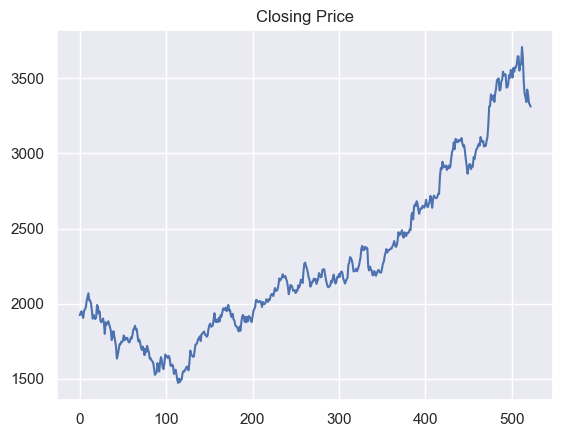

In [4]:
df_full['Close'].plot()
plt.title('Closing Price')

In [5]:
from collections import deque
import random

df= df_full.copy()
name = 'Double Duel Q-learning agent'

class Model:
    def __init__(self, input_size, output_size, layer_size, learning_rate):
        self.X = tf.placeholder(tf.float32, (None, input_size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        feed = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
        tensor_action, tensor_validation = tf.split(feed,2,1)
        feed_action = tf.layers.dense(tensor_action, output_size)
        feed_validation = tf.layers.dense(tensor_validation, 1)
        self.logits = feed_validation + tf.subtract(feed_action,tf.reduce_mean(feed_action,axis=1,keep_dims=True))
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 500
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    COPY = 1000
    T_COPY = 0
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.model = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.model_negative = Model(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        self.trainable = tf.trainable_variables()
    
    def _assign(self):
        for i in range(len(self.trainable)//2):
            assign_op = self.trainable[i+len(self.trainable)//2].assign(self.trainable[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, done):
        self.MEMORIES.append((state, action, reward, new_state, done))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state])
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states)
        Q_new = self.predict(new_states)
        Q_new_negative = self.sess.run(self.model_negative.logits, feed_dict={self.model_negative.X:new_states})
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, done_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.sess.run(self.model.logits, feed_dict={self.model.X:inputs})
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign()
                
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                
                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.model.cost, self.model.optimizer], 
                                        feed_dict={self.model.X: X, self.model.Y:Y})
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [10]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 400, checkpoint = 20, initial_money = initial_money)

C:\Users\soham\AppData\Local\Temp\ipykernel_15320\4118100945.py:11: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed = tf.layers.dense(self.X, layer_size, activation = tf.nn.relu)
C:\Users\soham\AppData\Local\Temp\ipykernel_15320\4118100945.py:13: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_action = tf.layers.dense(tensor_action, output_size)
C:\Users\soham\AppData\Local\Temp\ipykernel_15320\4118100945.py:14: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_validation = tf.layers.dense(tensor_validation, 1)
c:\Users\soham\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some case

epoch: 20, total rewards: 3278.349731.3, cost: 0.972035, total money: 6618.299683
epoch: 40, total rewards: 2021.050171.3, cost: 1.990954, total money: 8685.550171
epoch: 60, total rewards: 3841.998535.3, cost: 1.019097, total money: 10506.498535
epoch: 80, total rewards: 1389.249756.3, cost: 0.552370, total money: 7994.549805
epoch: 100, total rewards: 526.750732.3, cost: 1.005794, total money: 3495.450684
epoch: 120, total rewards: -763.748413.3, cost: 0.187306, total money: 5911.701538
epoch: 140, total rewards: 1975.500854.3, cost: 1.743918, total money: 11975.500854
epoch: 160, total rewards: 806.751343.3, cost: 0.446137, total money: 10806.751343
epoch: 180, total rewards: -54.199219.3, cost: 0.069523, total money: 3206.050781
epoch: 200, total rewards: -119.602295.3, cost: 0.395528, total money: 9880.397705
epoch: 220, total rewards: 352.999634.3, cost: 1.274475, total money: 3586.999634
epoch: 240, total rewards: 26.950317.3, cost: 0.119365, total money: 10026.950317
epoch: 260

In [41]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 15: buy 1 unit at price 1899.900024, total balance 8100.099976
day 16: buy 1 unit at price 1925.300049, total balance 6174.799927
day 17, sell 1 unit at price 1910.849976, investment 0.576344 %, total balance 8085.649902,
day 19, sell 1 unit at price 1909.199951, investment -0.836238 %, total balance 9994.849854,
day 26: buy 1 unit at price 1888.800049, total balance 8106.049805
day 27, sell 1 unit at price 1901.000000, investment 0.645910 %, total balance 10007.049805,
day 38: buy 1 unit at price 1777.050049, total balance 8229.999756
day 39, sell 1 unit at price 1816.750000, investment 2.234037 %, total balance 10046.749756,
day 56: buy 1 unit at price 1751.099976, total balance 8295.649780
day 57, sell 1 unit at price 1741.599976, investment -0.542516 %, total balance 10037.249756,
day 69: buy 1 unit at price 1760.800049, total balance 8276.449707
day 70, sell 1 unit at price 1738.349976, investment -1.274993 %, total balance 10014.799683,
day 87: buy 1 unit at price 1526.150024

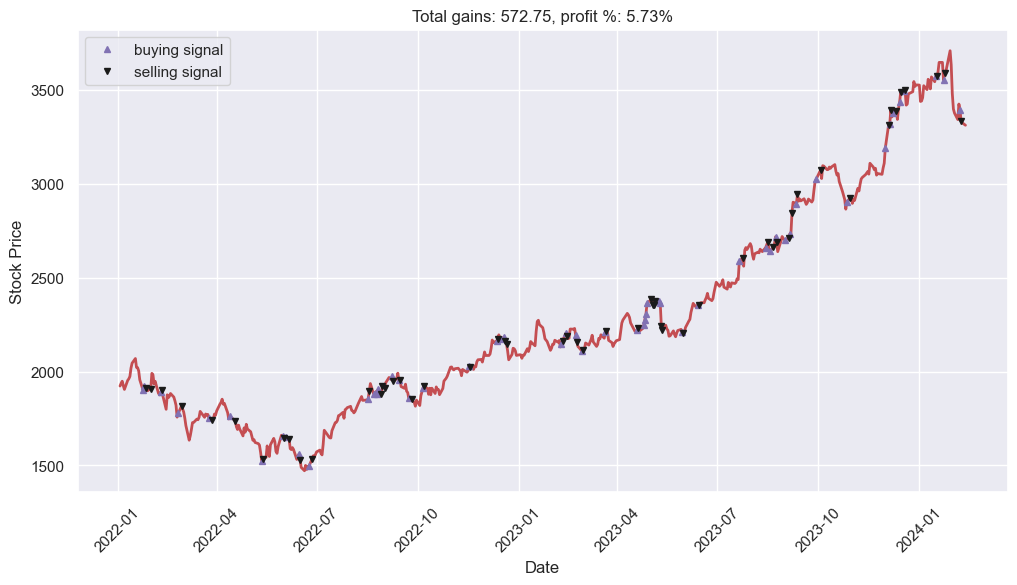

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Load the dataset
df = pd.read_csv('LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=5, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=5, color='k', label='selling signal')

plt.title('Total gains: %.2f, profit %%: %.2f%%' % (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()